# Performance Evaluation

In [1]:
import json
import torch
import numpy as np
import sys
import os

from tqdm import tqdm

from rdkit import Chem, RDLogger

# Shut up RDKit
logger = RDLogger.logger()
logger.setLevel(RDLogger.CRITICAL)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw

import random

import importlib

In [2]:
sys.path.append('./LSTM_TF/')
sys.path.append('./VANILLA_VAE/')

# from sd_lstm_utils import load_model as load_sd_lstm_model

from benchmark_vanilla_vae import VanillaVAEHarness

from model_vanilla_vae import VanillaMolVAE
from rnn_utils import load_model

from fast_rnn_sampler import FastSampler
# from rnn_sampler import ConditionalSmilesRnnSampler
from rnn_utils import load_rnn_model


sys.path.append('utils/')

from smiles_char_dict import SmilesCharDictionary
sd = SmilesCharDictionary()

from evaluation_utils import absolute_metrics, amina_metrics, property_metrics, props_from_smiles, plot_smiles, benchmark_reconstruction_QM9

In [3]:
sys.path.append('../utils/')
from property_calculator import PropertyCalculator

pc = PropertyCalculator(['LogP'])

# Load Models

In [5]:
# model_definit = 'models/NEW_LONG_RUNS/QM9/cVAE/SD_REG_VANILLA_VAE_dawn-band-89_Epoch_294_Vl_0.086.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/cVAE/SD_REG_VANILLA_VAE_dawn-band-89_Epoch_294_Vl_0.086.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/cVAE-KLD/SD_REG_VANILLA_VAE_ancient-paper-11_Epoch_235_Vl_0.353.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/cVAE-KLD/SD_REG_VANILLA_VAE_ancient-paper-11_Epoch_235_Vl_0.353.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/cVAE-Pol/SD_REG_VANILLA_VAE_still-field-09_Epoch_330_Vl_0.095.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/cVAE-Pol/SD_REG_VANILLA_VAE_still-field-09_Epoch_330_Vl_0.095.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/cVAE-Pol2/SD_REG_VANILLA_VAE_still-rain-34_Epoch_313_Vl_0.349.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/cVAE-Pol2/SD_REG_VANILLA_VAE_still-rain-34_Epoch_313_Vl_0.349.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/cVAE-KLD-Mean16/SD_REG_VANILLA_VAE_fragrant-fog-89_Epoch_99_Vl_0.064.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/cVAE-KLD-Mean16/SD_REG_VANILLA_VAE_fragrant-fog-89_Epoch_99_Vl_0.064.pt'

cvae_sampler = VanillaVAEHarness(batch_size=64, device='cpu')

cvae_model = load_model(model_class=VanillaMolVAE, model_definition=model_definit, model_weights=model_weights, device='cpu')

# ugly hack
cvae_model = cvae_model.to('cpu')
cvae_model.device = 'cpu'
cvae_model.encoder.device = 'cpu'
cvae_model.state_decoder.device = 'cpu'

a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited


In [4]:
# Load Explicit cVAE Model

# TODO: FIX NAME CLASHES
file_path = 'ACTION_SAMPLING_VANILLA_VAE/model_vanilla_vae.py'

# Load the module specified by the file path
spec = importlib.util.spec_from_file_location("model_vanilla_vae.py", file_path)
module = importlib.util.module_from_spec(spec)
sys.modules["model_vanilla_vae"] = module
spec.loader.exec_module(module)

explicit_model_class = module.VanillaMolVAE

file_path = 'ACTION_SAMPLING_VANILLA_VAE/action_sampling_vae_sampler.py'

# Load the module specified by the file path
spec = importlib.util.spec_from_file_location("action_sampling_vae_sampler.py", file_path)
module = importlib.util.module_from_spec(spec)
sys.modules["action_sampling_vae_sampler"] = module
spec.loader.exec_module(module)

harness_class = module.VanillaVAEHarness

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-TF10/SD_REG_VANILLA_VAE_bold-bonus-90_Epoch_216_Vl_0.034.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-TF10/SD_REG_VANILLA_VAE_bold-bonus-90_Epoch_216_Vl_0.034.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-KLD-TF10/SD_REG_VANILLA_VAE_small-lake-03_Epoch_110_Vl_0.119.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-KLD-TF10/SD_REG_VANILLA_VAE_small-lake-03_Epoch_110_Vl_0.119.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-KLD-TF10/SD_REG_VANILLA_VAE_small-lake-03_Epoch_156_Vl_0.114.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-KLD-TF10/SD_REG_VANILLA_VAE_small-lake-03_Epoch_156_Vl_0.114.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol/SD_REG_VANILLA_VAE_fragrant-math-98_Epoch_188_Vl_0.357.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol/SD_REG_VANILLA_VAE_fragrant-math-98_Epoch_188_Vl_0.357.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol-TF10/SD_REG_VANILLA_VAE_fancy-surf-43_Epoch_151_Vl_0.217.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol-TF10/SD_REG_VANILLA_VAE_fancy-surf-43_Epoch_151_Vl_0.217.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_shiny-sun-14_Epoch_170_Vl_0.244.json'
# model_weights= 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol2/SD_REG_VANILLA_VAE_shiny-sun-14_Epoch_170_Vl_0.244.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol2-TF10/SD_REG_VANILLA_VAE_weathered-meadow-69_Epoch_143_Vl_0.126.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-Pol2-TF10/SD_REG_VANILLA_VAE_weathered-meadow-69_Epoch_143_Vl_0.126.pt'

# model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE/SD_REG_VANILLA_VAE_wild-bush-15_Epoch_286_Vl_0.132.json'
# model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE/SD_REG_VANILLA_VAE_wild-bush-15_Epoch_286_Vl_0.132.pt'

model_definit = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-KLD/SD_REG_VANILLA_VAE_throbbing-mountain-59_Epoch_169_Vl_0.236.json'
model_weights = 'models/NEW_LONG_RUNS/QM9/EXP-cVAE-KLD/SD_REG_VANILLA_VAE_throbbing-mountain-59_Epoch_169_Vl_0.236.pt'

exp_cvae_sampler = harness_class(batch_size=64, device='cpu')

exp_cvae_model = load_model(model_class=explicit_model_class, model_definition=model_definit, model_weights=model_weights, device='cpu')


a Conv1d inited
a Conv1d inited
a Conv1d inited
a Linear inited
a Linear inited
a Linear inited
a GRU inited
a Linear inited


In [5]:
vae_model = exp_cvae_model
vae_sampler = exp_cvae_sampler

# Load Dataset

In [22]:
## ZINC
dataset_path = "data/ZINC250K/"
qmds = pd.read_csv(os.path.join(dataset_path, 'ZINC_clean.csv'))
print(qmds.columns)
props = list(qmds.drop(['ZINC_ID', 'SMILES'], axis=1).columns)
print(f'Properties in dataset: {props}')

# Seperate Test Train and Validation Datasets
indecies = np.load('data/ZINC250K/data_splits.npy')

train_smiles = np.array(qmds['SMILES'])[indecies == 0]
val_smiles = np.array(qmds['SMILES'])[indecies == 1]
test_smiles = np.array(qmds['SMILES'])[indecies == 2]

test_props = [ float(a) for a in pd.read_csv('data/ZINC250K/ZINC_clean.csv')['LogP'][indecies == 2]]

Index(['ZINC_ID', 'SMILES', 'LogP'], dtype='object')
Properties in dataset: ['LogP']


In [6]:
## QM9
dataset_path = "data/QM9/"
qmds = pd.read_csv(os.path.join(dataset_path, 'QM9_clean.csv'))
print(qmds.columns)
props = list(qmds.drop(['QM9_id', 'SMILES'], axis=1).columns)
print(f'Properties in dataset: {props}')

# Seperate Test Train and Validation Datasets
indecies = np.load('data/QM9/data_splits.npy')

train_smiles = np.array(qmds['SMILES'])[indecies == 0]
val_smiles = np.array(qmds['SMILES'])[indecies == 1]
test_smiles = np.array(qmds['SMILES'])[indecies == 2]

test_props = [ float(a) for a in pd.read_csv('data/QM9/QM9_clean.csv')['LogP'][indecies == 2]]

Index(['QM9_id', 'SMILES', 'LogP'], dtype='object')
Properties in dataset: ['LogP']


# Metric Computation

### TODO: Train Unconditional Version

In [7]:
def compute_prior_metrics_conditional_model(model, sampler, train_set, test_props, num_sample = 1000, num_decode = 100, return_valid = False):
    '''
    We sample 1000 latent representations z ∼ N (O, I). For each of them we decode 100 times, 
    and calculate the portion of 100,000 decoded results that corresponds to valid Program or SMILES sequences.

    %Valid = #Valid / #Generations
    %Unique = #Unique Valid / #Valid
    %Novel = #Valid - #Valid_in_train_set / #Valid
    MSE = Mse (target_property - achieved_property)^2
    '''

    # TODO: Currently hardcoded for ['LogP']
    
    # Check we have enough condit. values to give to model
    assert num_sample < len(test_props)
    train_set = set(train_set.copy())
    test_props = test_props.copy()

    # Get num_sample properties
    props = random.sample(test_props, num_sample)

    n_all_smiles = 0
    n_valid_smiles = 0
    n_valid_in_train = 0
    
    valid = []

    total_me = 0

    for prop in tqdm(props):
        repeated_prop = torch.tensor([[prop]] * num_decode)
        prop_smiles = sampler.sample(model, repeated_prop.clone())

        for smi in prop_smiles:
            n_all_smiles += 1
            # Check if valid
            mol = Chem.MolFromSmiles(smi)

            if mol is not None: # mol is valid
                can_smi = Chem.MolToSmiles(mol, canonical=True)
                n_valid_smiles += 1
                valid.append(can_smi)

                # Compute property
                # print( (pc(mol)[0] - prop) ** 2)
                total_me += abs( pc(mol)[0] - prop) # **2 MAE is better because less sensitive to outliers
                          
                # Check if in train set
                if can_smi in train_set:
                    n_valid_in_train += 1

    # Compute metrics

    if return_valid:
        return valid

    unique_valid = set(valid)
    validity = n_valid_smiles / n_all_smiles
    uniqueness = len(unique_valid) / n_valid_smiles
    novelty = (n_valid_smiles - n_valid_in_train) / n_valid_smiles
    mse = total_me / n_valid_smiles

    assert n_all_smiles == num_sample * num_decode

    return {'validity' : validity,
            'uniqueness' : uniqueness,
            'novelty' : novelty,
            'MAE': mse}

In [8]:
compute_prior_metrics_conditional_model(vae_model, vae_sampler, train_smiles, test_props = test_props, num_sample = 500, num_decode = 5, return_valid=False)

  0%|          | 0/500 [00:00<?, ?it/s]

/home/chrome/Code/MolGen/my_code/ACTION_SAMPLING_VANILLA_VAE/action_sampling_vae_sampler.py:152: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  properties = torch.tensor(properties).clone()
/home/chrome/Code/MolGen/my_code/ACTION_SAMPLING_VANILLA_VAE/model_vanilla_vae.py:315: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).float()
100%|██████████| 500/500 [02:09<00:00,  3.87it/s]


{'validity': 0.6848,
 'uniqueness': 0.9935747663551402,
 'novelty': 0.548481308411215,
 'MAE': 0.3167018516355142}

In [9]:
def smiles_to_tokens(test_smiles, max_seq_len):
    tokens = torch.zeros([len(test_smiles), max_seq_len], dtype=torch.long)
    
    for i in range(len(test_smiles)):
        smi = sd.encode(test_smiles[i])
        tokens[i][0] = sd.char_idx[sd.BEGIN]

        for j in range(len(smi)):
            tokens[i][j+1] = sd.char_idx[smi[j]]
            
        tokens[i][len(smi)+1] = sd.char_idx[sd.END]

    return tokens


def compute_reconstruction_vae_model(test_smiles, test_props, vae_model, vae_sampler, n_encodes = 10, n_decodes = 25):
    '''
    test_smiles is array-like of test smiles for reconstruction
    test_props is 

    n_encodes is number of encodings per test_set instance
    n_decodes is number of decodings per latent encoding

    Do one at a time since we're deconding 250x more points

    From SD-VAE paper:
    for each of the structured data in the held-out dataset, we encode it 10 times and decoded (for each encoded latent space representation) 25 times, and report the portion of decoded structures that are the same as the input ones
    '''
    n_same = 0
    n_total = 0
    
    test_props = test_props.copy()
        
    # Normalize properties
    edited_props = torch.tensor([[a] for a in test_props])

    # sampler.sample already normalizes properties
    # edited_props = vae_model.normalize_prop_scores(edited_props)

    vae_model.eval()
    vae_model.reparam = True

    for smindex in tqdm(range(len(test_smiles))):
        # max_seq_len = model.max_decode_steps
        # enc_b_size = n_encodes
        smile = test_smiles[smindex:smindex+1]
        prop = edited_props[smindex:smindex+1]

        # Convert smiles to tokens
        tokens = smiles_to_tokens(smile, vae_model.max_decode_steps)

        input_tokens = tokens.repeat(n_encodes, 1)
        input_properties = prop.repeat(n_encodes, 1)
        
        # Run through the model
        latent_points, log_var = vae_model.encoder(input_tokens)
        samp_latents = vae_model.reparameterize(mu = latent_points, logvar = log_var)# torch.tensor(vae_model.eps_std))

        # Repeat latents n_decode times
        # Repeat properties n_decode times
        samp_latents = samp_latents.repeat(n_decodes, 1) 
        repeated_props = input_properties.repeat(n_decodes, 1)

        sampled_smiles = vae_sampler.sample(model=vae_model, properties=repeated_props.clone(), random = True, latent_points = samp_latents)

        # Samp latents now contains n_encodings encoded (random latent points)
        # TODO: Do I reparam here? It's the only source of randomness for encodings but not how inference with a vae is typically done
        # feels right for judging the reconstruction loss though

        assert len(sampled_smiles) == n_encodes * n_decodes

        # Now decode probabilitically n_decode times
        counts = Counter(sampled_smiles)
        
        n_same += counts[smile[0]]

        n_total += len(sampled_smiles)

    return n_same / n_total


In [10]:
indices = random.sample(range(len(test_smiles)), 300)
smiles_1k = [test_smiles[i] for i in indices]
properties_1k = [test_props[i] for i in indices]
compute_reconstruction_vae_model(smiles_1k, properties_1k, vae_model, vae_sampler, n_encodes = 5, n_decodes = 5) #10 , 25


  0%|          | 0/300 [00:00<?, ?it/s]/home/chrome/Code/MolGen/my_code/ACTION_SAMPLING_VANILLA_VAE/action_sampling_vae_sampler.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  latent_points = torch.tensor(latent_points, dtype=torch.float32)
 72%|███████▏  | 215/300 [01:23<00:34,  2.50it/s]

## STYLE TRANSFER

In [28]:
style_transfer_smiles(source_smiles, source_props, target_props, vae_model, vae_sampler)

-- ACCIDENTALLY DELETED --

In [29]:
def compute_mean_property_error(properties_1, properties_2):
    '''
    Mae between two lists of properties ignoring indecies where either property is None
    '''
    total_mae = 0
    n_valid = 0

    assert len(properties_1) == len(properties_2)

    for i in range(len(properties_1)):
        if properties_1[i] is None or properties_2[i] is None:
            continue
        else:
            n_valid += 1
            # Compute MAE between generated LogP and original LogP
            total_mae += abs(properties_1[i] - properties_2[i])

    return total_mae / n_valid

In [30]:
def compute_avg_similarity(smiles_1, smiles_2, morgan_radius=2):
    '''
    Comptues average tanimoto similarity between two ordered lists of smiles

    Ignores invalid pairs
    '''
    assert len(smiles_1) == len(smiles_2)

    similarities = []
    n_valid = 0

    for i in range(len(smiles_1)):
        mol1 = Chem.MolFromSmiles(smiles_1[i])
        mol2 = Chem.MolFromSmiles(smiles_2[i])

        # Check validity
        if mol1 is None or mol2 is None:
            continue

        # Get fingerprints
        fing1 = AllChem.GetMorganFingerprint(mol1, radius=morgan_radius)
        fing2 = AllChem.GetMorganFingerprint(mol2, radius=morgan_radius)

        similarities.append(DataStructs.TanimotoSimilarity(fing1, fing2))
        n_valid += 1
    
    return sum(similarities) / n_valid


In [31]:
# PARAMETERS
n_samp = 1000

# Ensure we have enough smiles
assert 4 * n_samp <= len(test_smiles)

# Sample indices
all_indices = random.sample(range(len(test_smiles)), n_samp * 4)

# SAMPLE NON-OVERLAPPING INDICES
source_indices = all_indices[:n_samp]
target_indices = all_indices[n_samp:2*n_samp]
rand_dset_indices = all_indices[2*n_samp:3*n_samp]
rand_dec_indices = all_indices[3*n_samp:]


# Sample Source smiles to perform style transfer on
# source_indices = random.sample(range(len(test_smiles)), n_samp)
source_smiles = [test_smiles[i] for i in source_indices]
source_props = [test_props[i] for i in source_indices]

# Sample Target properties (and smiles) to transfer onto source molecules
# target_indices = random.sample(range(len(test_smiles)), n_samp)
target_smiles = [test_smiles[i] for i in target_indices]
target_props = [test_props[i] for i in target_indices]

# Perform Style Transfer
generated_smiles = style_transfer_smiles(source_smiles, source_props, target_props, vae_model, vae_sampler)

# Compute properties for style transfer results
generated_mols = [ Chem.MolFromSmiles(a) for a in generated_smiles]
generated_props = [ None if a is None else pc(a)[0] for a in generated_mols]

# Sample random [dataset] properties and smiles 
# rand_dset_indices =  random.sample(range(len(test_smiles)), n_samp)
rand_dset_smiles = [test_smiles[i] for i in rand_dset_indices]
rand_dset_props = [test_props[i] for i in rand_dset_indices]

# random [decoder | dataset] properties and smiles
# rand_dec_indices = random.sample(range(len(test_smiles)), n_samp)
rand_dec_input_props = [test_props[i] for i in rand_dec_indices]
rand_dec_input_props_formatted = torch.tensor([[a] for a in rand_dec_input_props])

rand_dec_smiles = vae_sampler.sample(model=vae_model, properties=rand_dec_input_props_formatted)
rand_dec_mols = [ Chem.MolFromSmiles(a) for a in rand_dec_smiles]
rand_dec_props = [ None if a is None else pc(a)[0] for a in rand_dec_mols]

In [32]:
'''
MEAN ERROR BETWEEN SOURCE PROPERTIES AND GENERATED PROPERTIES
 - Ideally should be bad, close to mean error between random decoder and dataset properties
'''

mae_source_gen = compute_mean_property_error(source_props, generated_props)
print(f' MAE Between Generated and Source properties (should be close to random): {mae_source_gen}\n')


'''
MEAN ERROR BETWEEN RANDOM DATASET PROPERTIES AND DECODER PROPERTIES
 - Benchmark for source - generated error
'''

mae_random_dset_gen = compute_mean_property_error(rand_dec_props, rand_dset_props)
print('NOTE: I question this metric.')
print(f' MAE Between random dataset properties and random decoder properties: {mae_random_dset_gen}\n')


print()
print()
print()

'''
MEAN ERROR BETWEEN TARGET PROPERTIES AND GENERATED PROPERTIES
 - Should be as small as possible, ideally equal to the mean error for conditional generation
'''

mae_target_gen = compute_mean_property_error(target_props, generated_props)
print(f' MAE Between Generated and Target properties (should be small; close to cond_gen performance): {mae_target_gen}\n')

'''
MEAN ERROR FOR CONDITIONAL GENERATION
'''
# mae_cond_gen = compute_mean_property_error(rand_dec_input_props, rand_dec_props)
# print(f' Cond Gen MAE: {mae_cond_gen}\n')


 MAE Between Generated and Source properties (should be close to random): 0.7116624771689499

NOTE: I question this metric.
 MAE Between random dataset properties and random decoder properties: 1.2509495588235293




 MAE Between Generated and Target properties (should be small; close to cond_gen performance): 0.6156799315068493



'\nMEAN ERROR FOR CONDITIONAL GENERATION\n'

In [33]:
morgan_rad = 3

'''
SIMILARITY BETWEEN TARGET SMILES AND GENERATED SMILES
Should be low, ideally near the similarity of random smiles from the decoder with random smiles from the generator
'''

sim_tgt_gen = compute_avg_similarity(target_smiles, generated_smiles, morgan_radius=morgan_rad)
print(f'Similarity between target and geneated smiles (Should be as low as possible): {sim_tgt_gen}')


'''
SIMILARITY BETWEEN SOURCE SMILES AND GENERATED SMILES
Should be as high as possible
'''

sim_source_gen = compute_avg_similarity(source_smiles, generated_smiles, morgan_radius=morgan_rad)
print(f'Similarity between source and geneated smiles (Should be as high as possible): {sim_source_gen}')


print('\n\n')

'''
Similarity of random decoder with random dataset smiles
'''
sim_rdn_dec_dset = compute_avg_similarity(rand_dec_smiles, rand_dset_smiles, morgan_radius=morgan_rad)

print(f'Similarity between random decoder and dataset smiles (Random Baseline): {sim_rdn_dec_dset}')

'''
Percentage of cases in witch style transfer fails and the decoder reproduces the source molecules
'''
n_valid = 0
n_fail = 0
for i in range(len(source_smiles)):
    # Ignore invalid
    if generated_props[i] is None:
        continue
    n_valid += 1
    if generated_smiles[i] == source_smiles[i]:
        n_fail += 1

pct_fail = n_fail / n_valid

print('\n')
print(f'PCT Failure to change source molecule: {pct_fail}')

Similarity between target and geneated smiles (Should be as low as possible): 0.06975338344488295
Similarity between source and geneated smiles (Should be as high as possible): 0.5852647137350744



Similarity between random decoder and dataset smiles (Random Baseline): 0.0659758099823732


PCT Failure to change source molecule: 0.3470319634703196


In [34]:
def plot_style_transfer(og_smiles, og_props, random_props, st_smiles, st_props):
    """
    Plots a comparison of original and style-transferred SMILES molecules,
    skipping entries where the style-transferred property is None or SMILES
    cannot be converted to a molecule object.

    Parameters:
    - og_smiles: List of original SMILES strings sampled from the dataset.
    - og_props: List of original properties corresponding to the original SMILES.
    - random_props: List of random properties used for style transfer sampled from the dataset.
    - st_smiles: List of SMILES strings after style transfer.
    - st_props: List of properties for the style-transferred SMILES.
    """
    filtered_indices = [i for i in range(len(st_props)) if st_props[i] is not None]

    # Create a subplot of n rows and 2 columns, checking the count of valid entries
    n = len(filtered_indices)
    if n == 0:
        print("No valid entries to plot.")
        return

    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(10, n * 3))
    if n == 1:  # Adjust axes array for single subplot scenario
        axes = [axes]

    row = 0
    for i in filtered_indices:
        og_mol = Chem.MolFromSmiles(og_smiles[i])
        st_mol = Chem.MolFromSmiles(st_smiles[i])

        if og_mol is None or st_mol is None:
            continue  # Skip if any molecule could not be generated

        og_img = Draw.MolToImage(og_mol)
        st_img = Draw.MolToImage(st_mol)

        # Plot original molecule
        axes[row, 0].imshow(og_img)
        axes[row, 0].axis('off')
        axes[row, 0].set_title(f'Source Molecule \n LogP: {og_props[i]}')

        # Plot style transferred molecule
        axes[row, 1].imshow(st_img)
        axes[row, 1].axis('off')
        axes[row, 1].set_title(f'Generated Molecule \n LogP: {st_props[i]}\n Target LogP: {random_props[i]}')

        row += 1  # Increment row counter only when a pair is actually plotted
    
    plt.tight_layout()
    plt.show()

In [35]:
# sample(self, model, properties, random=True, latent_points = None)
# sd.decode()
sample_props = np.array( [[a] for a in random.choices(test_props, k=50)])
print(list(vae_sampler.sample(vae_model, torch.tensor(sample_props).clone())))

['CC(CCCC1CN2C1=O', 'C1OCC2CNC121CO1', 'CC(CCC#CCNC11=1', 'COC(CC=C)=CC1=O', 'COCCCCCNC=CC1=O', 'COOCCC1CCC2CO=O', 'C1OC2C1CC2CC1=O', 'CCN1CNC1C1CC1=O', 'CN1CCNCNC12C1=O', 'C1OC2C1CCC2C1=O', 'CCCCC=NNC22C1=O', 'CCOCCC1CC=2C1=O', 'CCNCCCCNC22C1=O', 'CN1CCN1CC22CO=O', 'CO(CCCC1C=CC1=O', 'CC(CCCC1)N=CO=O', 'CN1CC=C1C1CC1=O', 'CNOCCNCCC2CC1=O', 'CCNCCNCNC2CC1=O', 'C1OCCN1CC2OC1=O', 'C1=CCCCCC12CC21', 'CCCCCCCNCNCC1=O', 'C1OC2C1NC1CC1=O', 'CN1CC=CCC12C1=O', 'CCO1CC=CC2CC1=O', 'C1OC2C1NCC211=1', 'C1OC2C1CCCCC1=O', 'CC(CCCC1C1=CO=O', 'CCNCC=N1C1NC1=O', 'COCNCNC1C12C1=O', 'CCNC(N1CC1CC1=', 'C1OC2C1CCC2CC=O', 'CCO1C==NCCCC1=O', 'C1OC2C1CC2211=O', 'CN1CC=C=C1C1C=1', 'C1OC2C1CCC21C=1', 'C11CC=CNC1C11O1', 'CCC1CC=CCN=C1=O', 'CCCCCN1NC2CC1=O', 'CCCCCC11CCCCO1', 'CCOC(CCC)C=CO=O', 'CC=CCNCCC1C1CO1', 'C1OC2C1CCC2CC=1', 'C1OC2C1NCCCCO=O', 'CCOCCN1CC12C1=O', 'CO(CCCC1)NC1=NC', 'C1OC2C1NC2C1CO1', 'CCNCC=CNC1CC1=1', 'CN(CCCCCC12C1=O', 'CCCCCCC1C=CC1=O']


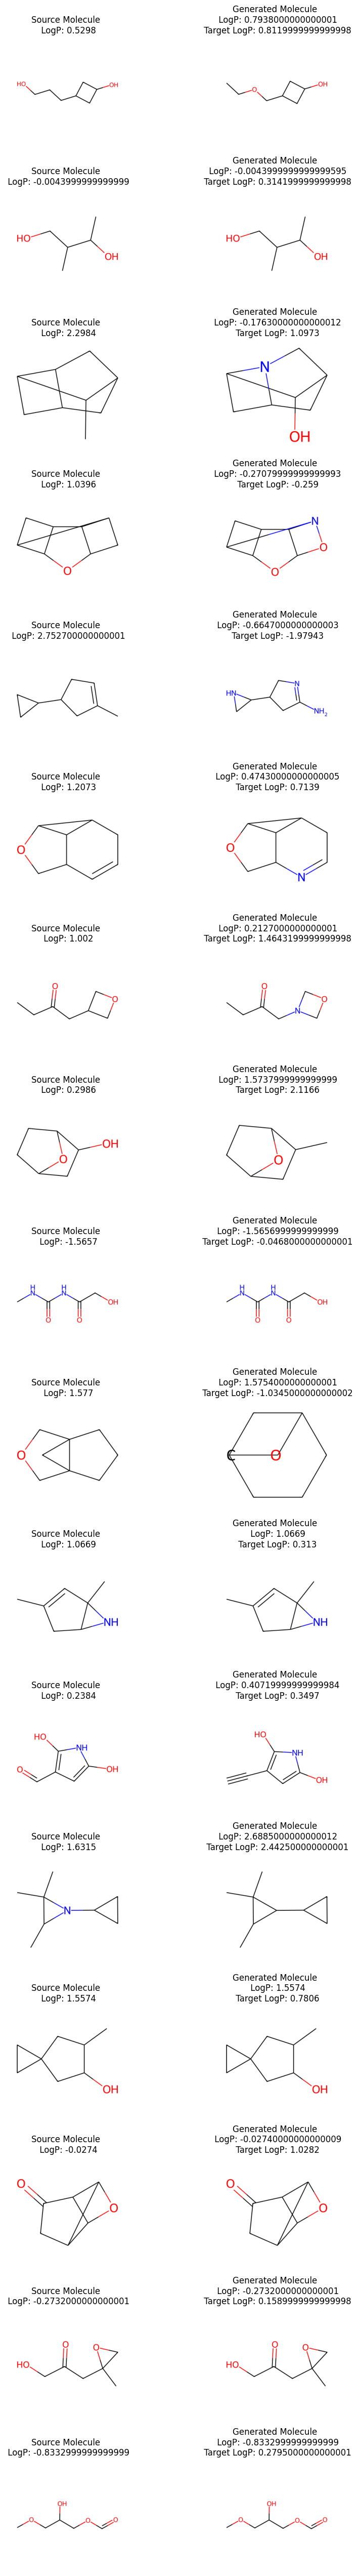

In [36]:
n_to_plot = 20
offset = 30

plot_style_transfer(
    og_smiles = source_smiles[offset:offset+n_to_plot],
    og_props = source_props[offset:offset+n_to_plot],
    random_props = target_props[offset:offset+n_to_plot],
    st_smiles = generated_smiles[offset:offset+n_to_plot],
    st_props = generated_props[offset:offset+n_to_plot])


## LSTM EVALUATION

In [68]:
# Load SD-LSTM Model
# lstm_params = 'models/LONG_RUNS/ZINC/LSTM/LSTM_final_0.769.pt'
# lstm_definit = 'models/LONG_RUNS/ZINC/LSTM/LSTM_final_0.769.json'

# lstm_definit = 'models/NEW_LONG_RUNS/QM9/LSTM/LSTM_3_1.216.json'
# lstm_params = 'models/NEW_LONG_RUNS/QM9/LSTM/LSTM_3_1.216.pt'

# lstm_definit = 'models/NEW_LONG_RUNS/QM9/LSTM/LSTM_7_1.224.json'
# lstm_params = 'models/NEW_LONG_RUNS/QM9/LSTM/LSTM_7_1.224.pt'

# lstm_definit = 'models/NEW_LONG_RUNS/QM9/LSTM/LSTM_22_1.158.json'
# lstm_params = 'models/NEW_LONG_RUNS/QM9/LSTM/LSTM_22_1.158.pt'

# lstm_definit = 'models/NEW_LONG_RUNS/QM9/LSTM/LSTM_82_1.141.json'
# lstm_params = 'models/NEW_LONG_RUNS/QM9/LSTM/LSTM_82_1.141.pt'

# lstm_definit = 'models/LSTM_QM9/batch_size_64_2/LSTM_20_1.190.json'
# lstm_params = 'models/LSTM_QM9/batch_size_64_2/LSTM_20_1.190.pt'

lstm_definit = '../my_code_upload_old_params/models/LSTM_QM9/batch_size_64_2/LSTM_10_1.211.pt'
lstm_params = '../my_code_upload_old_params/models/LSTM_QM9/batch_size_64_2'

lstm_sampler = FastSampler(device = 'cpu', batch_size=64)
lstm_model = load_rnn_model(
            model_definition= lstm_definit,
            model_weights = lstm_params,
            device = 'cpu',
            )

In [69]:
def compute_metrics_lstm(lstm_sampler, lstm_model, target_props, train_smiles, seq_len = 278):
    # Sample smiles from property scores

    raise Exception('Check Normalization')
    sample_smiles = lstm_sampler.sample(model=lstm_model, properties=target_props.clone(), num_to_sample=len(target_props), max_seq_len=seq_len)
    assert len(sample_smiles) == len(target_props)
    n_decodes = 0
    n_valid = 0
    n_valid_in_train = 0
    unique_valid = set()
    total_se = 0.0
    train_set = set(train_smiles)

    for i in range(len(sample_smiles)):
        n_decodes += 1
        smi = sample_smiles[i]
        prop = target_props[i]

        mol = Chem.MolFromSmiles(smi)

        if mol is not None:
            n_valid += 1
            can_smi = Chem.MolToSmiles(mol, canonical=True)
            unique_valid.add(can_smi)
            
            total_se += ( pc(mol)[0] - prop)**2
                          
        # Check if in train set
        if can_smi in train_set:
            n_valid_in_train += 1

    validity = n_valid / n_decodes
    uniqueness = len(unique_valid) / n_valid
    novelty = (n_valid - n_valid_in_train) / n_valid
    mse = total_se / n_valid


    return validity, uniqueness, novelty, mse

In [70]:
target_props = random.choices(test_props, k=300)
target_props = torch.tensor([[a] for a in target_props])

In [71]:
compute_metrics_lstm(lstm_sampler, lstm_model, train_smiles=train_smiles, target_props=target_props)

(1.0, 0.24, 0.043333333333333335, tensor([0.1025]))

## Property Error Baseline

In [13]:
def mean_squared_error(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Lists must have the same length")
    
    mse = sum((a - b) ** 2 for a, b in zip(list1, list2)) / len(list1)
    return mse

In [14]:
propsA = test_props
propsB = random.sample(test_props, len(test_props))

mse = mean_squared_error(propsA, propsB)
print(f'Baseline MAE is: {mse}')

Baseline MSE is: 2.003641019857367


In [16]:
mean = np.mean(test_props) 
propsMean = [mean for _ in range(len(test_props))]

mse = mean_squared_error(propsMean, propsA)
print(f'Baseline MAE is: {mse}')

Baseline MSE is: 0.9960336400890705
